Comp 579 Project

Implementing and comparing algorithms in sparse reward environments and seeing the effect of continiously training off key states (non-zero reward)

In [7]:
import random
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchrl.modules.distributions import MaskedCategorical
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
#Define env
from pettingzoo.classic import connect_four_v3
env = connect_four_v3.env()

In [9]:
print(env.observation_space(env.possible_agents[0]))
print(env.action_space(env.possible_agents[0]).n)

Dict('action_mask': Box(0, 1, (7,), int8), 'observation': Box(0, 1, (6, 7, 2), int8))
7


Two player

In [10]:
class ActorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=4, kernel_size=2), #Input 6x7 #Out 5x6
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=2), #In 5x6 #Out 4x5
            nn.Flatten(),
        )
        self.linear = nn.Sequential(
            nn.Linear(80,64), #4x4x5 -> 80
            nn.ReLU(),
            nn.Linear(64,7),
            nn.Softmax(dim=1),
        )
    def forward(self, x):
        x = self.layer(x)
        x = self.linear(x)
        return x

class ValueNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=4, kernel_size=2), #Input 6x7 #Out 5x6
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=2), #In 5x6 #Out 4x5
            nn.Flatten(),
        )
        self.linear = nn.Sequential(
            nn.Linear(80,64), #4x4x5 -> 80
            nn.ReLU(),
            nn.Linear(64,1),
        )
    def forward(self, x):
        x = self.layer(x)
        x = self.linear(x)
        return x


class A2C:
    def __init__(self):
        self.actor_func = ActorNet().to(device)
        self.value_func = ValueNet().to(device)
        self.opt_val = torch.optim.AdamW(self.value_func.parameters(), lr=0.0001)
        self.opt_actor = torch.optim.AdamW(self.actor_func.parameters(), lr=0.0001)
        self.loss_MSE = torch.nn.MSELoss()
        self.I = 1

    def new_episode(self):
        self.I = 1
        
    def choose_action(self, observation, greedy=False):
        mask = torch.BoolTensor(observation["action_mask"]).to(device)
        obs = torch.tensor(observation['observation'].reshape(1, 2, 6, 7)).to(device).float()
        logits = self.actor_func(obs)
        if greedy:
            return torch.argmax(mask * logits).tolist(), 0
        #print(logits)
        m = MaskedCategorical(logits, mask=mask)
        action = m.sample()
        #print(action.cpu().detach().numpy()[0])
        return action.tolist()[0], m.log_prob(action)
    
    def update(self, state, logProb, reward, next_state, termination ):
        state =  torch.tensor(state.reshape(-1, 2, 6,7)).to(device).float()
        next_state =  torch.tensor(next_state.reshape(-1, 2, 6, 7)).to(device).float()
        reward = torch.tensor(reward).to(device)
        #Calculate value loss
        final_state_check = torch.tensor((1-termination)).to(device).float()
        v_pred = self.value_func(state).float().squeeze()
        target_v = final_state_check * gamma
        target_v *= self.value_func(next_state).float().squeeze()
        target_v += reward
        #reward+ final_state_check * gamma * self.value_func(next_state)
        #Update Value Network using MSE error
        loss_val = self.loss_MSE(v_pred, target_v)
        loss_val *= self.I
        ############################
        
        #Update policy loss
        advantage = target_v - v_pred
        loss_policy = logProb * advantage
        loss_policy *= self.I
        #print(loss_policy.size())
        self.opt_actor.zero_grad()
        loss_policy.backward(retain_graph=True)
        self.opt_actor.step()
        
        #Update value loss
        self.opt_val.zero_grad()
        loss_val.backward()
        self.opt_val.step()
        self.I *= gamma
        return loss_policy

In [11]:
agent_0 = A2C()
agent_1 = A2C()

In [6]:
print(agent_0.actor_func)

ActorNet(
  (layer): Sequential(
    (0): Conv2d(2, 4, kernel_size=(2, 2), stride=(1, 1))
    (1): Conv2d(4, 4, kernel_size=(2, 2), stride=(1, 1))
    (2): Flatten(start_dim=1, end_dim=-1)
  )
  (linear): Sequential(
    (0): Linear(in_features=80, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=7, bias=True)
    (3): Softmax(dim=1)
  )
)


In [12]:
agent_0.actor_func.load_state_dict(torch.load("./agent0_actor_weights.pt"))
agent_0.value_func.load_state_dict(torch.load("./agent0_value_weights.pt"))
agent_1.actor_func.load_state_dict(torch.load("./agent1_actor_weights.pt"))
agent_1.value_func.load_state_dict(torch.load("./agent1_value_weights.pt"))

<All keys matched successfully>

# Two networks playing against each other

###

In [6]:
from pettingzoo.classic import connect_four_v3
env = connect_four_v3.env()

In [7]:
gamma = 1
returns = []
losses_agent0 = []
losses_agent1 = []
rewards_agent0 = []
rewards_agent1 = []
greedy_agents = False
episodes = 50_000
#env = connect_four_v3.env(render_mode="human")
for episode in tqdm(range(episodes)):
    env.reset()
    step = 2
    #p0
    agent_1.new_episode()
    agent_0.new_episode()
    #
    observation_p0, reward, termination, truncation, info = env.last()
    action_p0, logProb_p0 = agent_0.choose_action(observation_p0, greedy=greedy_agents)
    env.step(action_p0)
    #p1
    observation_p1, reward, termination, truncation, info = env.last()
    action_p1, logProb_p1 = agent_1.choose_action(observation_p1, greedy=greedy_agents)
    env.step(action_p1)
    #
    for agent in env.agent_iter():
        ######
        observation_p0_prime, reward, termination, truncation, info = env.last()
        #Update
        agent_0.update(observation_p0["observation"],  logProb_p0, reward, observation_p0_prime["observation"], termination)
        rewards_agent0 += [reward]
        observation_p0 = observation_p0_prime
        #Choose action for player 0 
        if termination or truncation:
            #Update p1 and end
            env.step(None)
            observation_p1_prime, reward, termination, truncation, info = env.last()
            agent_1.update(observation_p1["observation"], logProb_p1, reward, observation_p1_prime["observation"], termination)
            rewards_agent1+= [reward]
            break
        action_p0, logProb_p0 = agent_0.choose_action(observation_p0, greedy=greedy_agents)
        env.step(action_p0)
        ##################################################################
        observation_p1_prime, reward, termination, truncation, info = env.last()
        #Update
        agent_1.update(observation_p1["observation"], logProb_p1, reward, observation_p1_prime["observation"], termination)
        rewards_agent1+=[reward]
        observation_p1 = observation_p1_prime
        #Choose action for player 1
        if termination or truncation:
            #Update p0 and end
            env.step(None)
            observation_p0_prime, reward, termination, truncation, info = env.last()
            agent_0.update(observation_p0["observation"],  logProb_p0, reward, observation_p0_prime["observation"], termination)
            rewards_agent0+=[reward]
            break
        action_p1, logProb_p1 = agent_1.choose_action(observation_p1, greedy=greedy_agents)
        env.step(action_p1)
        #################
env.close()

100%|██████████| 50000/50000 [5:03:17<00:00,  2.75it/s]  


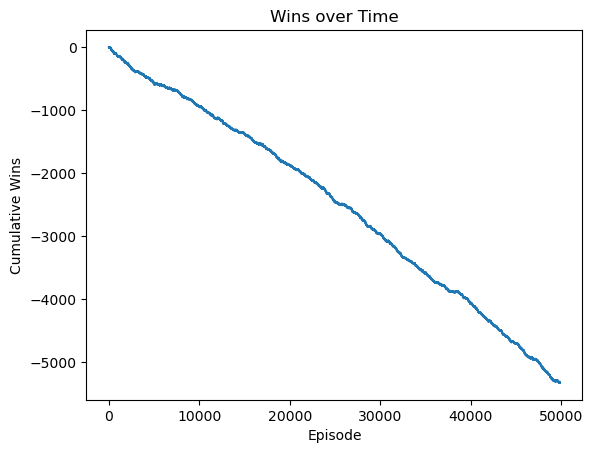

In [9]:
arr = [i for i in rewards_agent1 if i != 0]

plt.plot([sum(arr[:i]) for i in range(len(arr))])
plt.xlabel("Episode")
plt.ylabel("Cumulative Wins")
plt.title("Wins over Time")
plt.savefig("agent1_connect4_a2c_cumuWins.png", bbox_inches='tight')

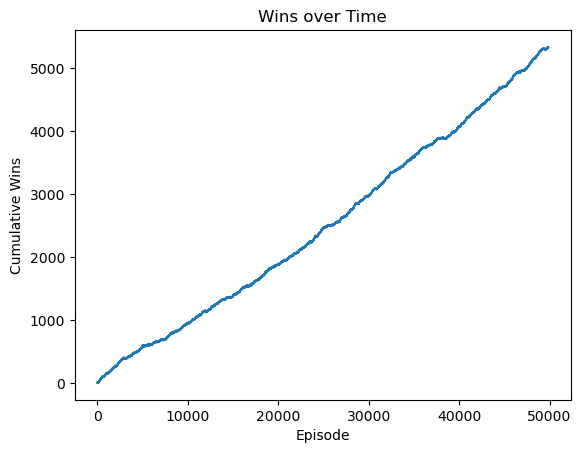

In [10]:
arr = [i for i in rewards_agent0 if i != 0]

plt.plot([sum(arr[:i]) for i in range(len(arr))])
plt.xlabel("Episode")
plt.ylabel("Cumulative Wins")
plt.title("Wins over Time")
plt.savefig("agent0_connect4_a2c_cumuWins.png", bbox_inches='tight')

In [8]:
torch.save(agent_0.actor_func.state_dict(), "./agent0_actor_weights.pt")
torch.save(agent_0.value_func.state_dict(), "./agent0_value_weights.pt")
torch.save(agent_1.actor_func.state_dict(), "./agent1_actor_weights.pt")
torch.save(agent_1.value_func.state_dict(), "./agent1_value_weights.pt")

# Train the second agent for a few more steps

In [14]:
gamma = 1
returns = []
losses_agent0 = []
losses_agent1 = []
rewards_agent0 = []
rewards_agent1 = []
greedy_agents = False
episodes = 5000
#env = connect_four_v3.env(render_mode="human")
for episode in tqdm(range(episodes)):
    env.reset()
    step = 2
    #p0
    agent_1.new_episode()
    #
    observation_p0, reward, termination, truncation, info = env.last()
    action_p0, logProb_p0 = agent_0.choose_action(observation_p0, greedy=greedy_agents)
    env.step(action_p0)
    #p1
    observation_p1, reward, termination, truncation, info = env.last()
    action_p1, logProb_p1 = agent_1.choose_action(observation_p1, greedy=greedy_agents)
    env.step(action_p1)
    #
    for agent in env.agent_iter():
        ######
        observation_p0_prime, reward, termination, truncation, info = env.last()
        #Update
        #agent_0.update(observation_p0["observation"],  logProb_p0, reward, observation_p0_prime["observation"], termination)
        rewards_agent0 += [reward]
        observation_p0 = observation_p0_prime
        #Choose action for player 0 
        if termination or truncation:
            #Update p1 and end
            env.step(None)
            observation_p1_prime, reward, termination, truncation, info = env.last()
            agent_1.update(observation_p1["observation"], logProb_p1, reward, observation_p1_prime["observation"], termination)
            rewards_agent1+= [reward]
            break
        action_p0, logProb_p0 = agent_0.choose_action(observation_p0, greedy=greedy_agents)
        env.step(action_p0)
        ##################################################################
        observation_p1_prime, reward, termination, truncation, info = env.last()
        #Update
        agent_1.update(observation_p1["observation"], logProb_p1, reward, observation_p1_prime["observation"], termination)
        rewards_agent1+=[reward]
        observation_p1 = observation_p1_prime
        #Choose action for player 1
        if termination or truncation:
            #Update p0 and end
            env.step(None)
            observation_p0_prime, reward, termination, truncation, info = env.last()
            #agent_0.update(observation_p0["observation"],  logProb_p0, reward, observation_p0_prime["observation"], termination)
            rewards_agent0+=[reward]
            break
        action_p1, logProb_p1 = agent_1.choose_action(observation_p1, greedy=greedy_agents)
        env.step(action_p1)
        #################
env.close()

100%|██████████| 5000/5000 [18:01<00:00,  4.62it/s]


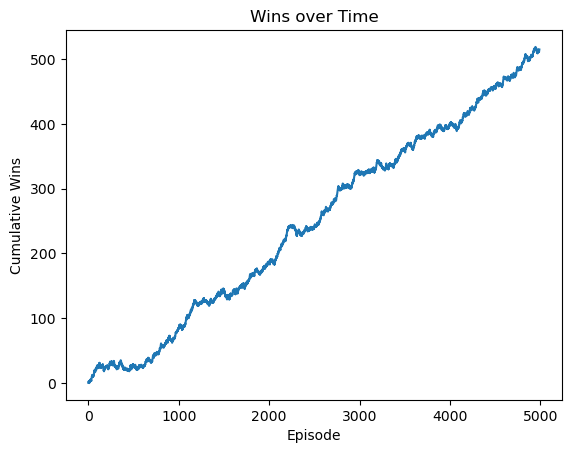

In [15]:
arr = [i for i in rewards_agent0 if i != 0]

plt.plot([sum(arr[:i]) for i in range(len(arr))])
plt.xlabel("Episode")
plt.ylabel("Cumulative Wins")
plt.title("Wins over Time")
plt.savefig("agent0_connect4_a2c_cumuWins_CONT.png", bbox_inches='tight')

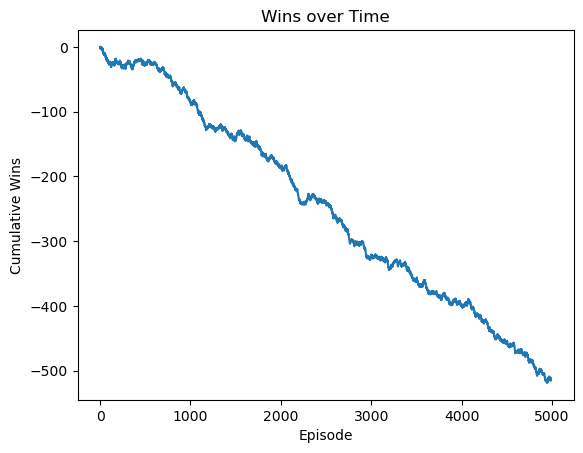

In [16]:
arr = [i for i in rewards_agent1 if i != 0]

plt.plot([sum(arr[:i]) for i in range(len(arr))])
plt.xlabel("Episode")
plt.ylabel("Cumulative Wins")
plt.title("Wins over Time")
plt.savefig("agent1_connect4_a2c_cumuWins_CONT.png", bbox_inches='tight')

#DQN vs A2C

In [23]:
class dqn_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=8, kernel_size=2), #Input 6x7 #Out 5x6
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=2), #In 5x6 #Out 4x5
            nn.Flatten(),
        )
        self.linear = nn.Sequential(
            nn.Linear(160,128), #8x4x5 -> 80
            nn.ReLU(),
            nn.Linear(128,7)
        )
    def forward(self, x):
        x = self.layer(x)
        x = self.linear(x)
        return x

In [24]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, mask, action, reward, next_state, next_mask, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, mask, action, reward, next_state, next_mask, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, mask, action, reward, next_state, next_mask, done = map(np.stack, zip(*batch))
        return state, mask, action, reward, next_state, next_mask, done
    
    def __len__(self):
        return len(self.buffer)

In [25]:
class DQN:
    def __init__(self):
        self.q_network = dqn_net().to(device)
        self.opt_q = torch.optim.AdamW(self.q_network.parameters(), lr=0.001)
        self.replay_buffer_size = 10000000
        self.replay_buffer = ReplayBuffer(self.replay_buffer_size)
        self.MSE = torch.nn.MSELoss()
        self.batch_size = 128
        self.epsilon = 1/10
        
    def update(self):
        state, mask, action, reward, next_state, next_mask, termination = self.replay_buffer.sample(self.batch_size)
        state =  torch.tensor(state.reshape(-1, 2, 6,7)).to(device).float()
        next_state =  torch.tensor(next_state.reshape(-1, 2, 6, 7)).to(device).float()
        final_state_check = torch.tensor((1-termination)).to(device)
        reward = torch.tensor(reward).to(device)
        target = torch.max(self.q_network(next_state), dim=1)[0]
        target *= final_state_check
        target *= gamma
        target += reward
        #target = reward + final_state_check * gamma * torch.max(self.q_network(next_state), dim=1)[0]
        self.opt_q.zero_grad()
        loss = self.MSE(target, self.q_network(state)[torch.arange(self.batch_size), action])
        loss.backward()
        self.opt_q.step()
        return loss.item()
    
    def update_given_buffer(self, replay_buffer):
        state, mask, action, reward, next_state, next_mask, termination = replay_buffer.sample(self.batch_size)
        state =  torch.tensor(state.reshape(-1, 2, 6,7)).to(device).float()
        next_state =  torch.tensor(next_state.reshape(-1, 2, 6, 7)).to(device).float()
        final_state_check = torch.tensor((1-termination)).to(device)
        reward = torch.tensor(reward).to(device)
        target = torch.max(self.q_network(next_state), dim=1)[0]
        target *= final_state_check
        target *= gamma
        target += reward
        #target = reward + final_state_check * gamma * torch.max(self.q_network(next_state), dim=1)[0]
        self.opt_q.zero_grad()
        loss = self.MSE(target, self.q_network(state)[torch.arange(self.batch_size), action])
        loss.backward()
        self.opt_q.step()
        return loss.item()   
    
    def choose_action(self, state, greedy= False):
        mask = state["action_mask"]
        indices_of_ones = np.where(mask == 1)[0]
        action_random = np.random.choice(indices_of_ones)
        mask = torch.tensor(np.where(mask==0, -np.infty, 0), dtype=torch.float32).to(device).float()
        #print(mask)
        state = torch.tensor(state['observation'].reshape(1, 2, 6, 7)).to(device).float()
        logits = self.q_network(state)
        action_greedy = torch.argmax(mask + logits).tolist()
        if greedy:
            return action_greedy
        return np.random.choice([action_random, action_greedy], p=[self.epsilon, 1-self.epsilon])

In [26]:
agent_0 = DQN()
agent_0.q_network.load_state_dict(torch.load("./agent0_q_weights.pt"))

<All keys matched successfully>

In [31]:
gamma = 1
returns = []
losses_agent0 = []
losses_agent1 = []
rewards_agent0 = []
rewards_agent1 = []
greedy_agents = False
episodes = 1000
env = connect_four_v3.env(render_mode="human")
episode_lengths = []
for episode in tqdm(range(episodes)):
    env.reset()
    #p0
    observation_p0, reward, termination, truncation, info = env.last()
    action_p0 = agent_0.choose_action(observation_p0, greedy=greedy_agents)
    env.step(action_p0)
    #p1
    observation_p1, reward, termination, truncation, info = env.last()
    action_p1, logProb_p1 = agent_1.choose_action(observation_p1, greedy=greedy_agents)
    env.step(action_p1)
    #
    for agent in env.agent_iter():        ######
        observation_p0_prime, reward, termination, truncation, info = env.last()
        #Update
        rewards_agent0 += [reward]
        observation_p0 = observation_p0_prime
        #Choose action for player 0 
        if termination or truncation:
            #Update p1 and end
            env.step(None)
            observation_p1_prime, reward, termination, truncation, info = env.last()
            rewards_agent1+= [reward]
            break
        action_p0 = agent_0.choose_action(observation_p0, greedy=greedy_agents)
        env.step(action_p0)
        ##################################################################
        observation_p1_prime, reward, termination, truncation, info = env.last()
        #Update
        rewards_agent1+=[reward]
        observation_p1 = observation_p1_prime
        #Choose action for player 1
        if termination or truncation:
            #Update p0 and end
            env.step(None)
            observation_p0_prime, reward, termination, truncation, info = env.last()
            rewards_agent0+=[reward]
            break
        action_p1, logProb_p1 = agent_1.choose_action(observation_p1, greedy=greedy_agents)
        env.step(action_p1)
        #################
env.close()

  0%|          | 4/1000 [00:18<1:16:24,  4.60s/it]


KeyboardInterrupt: 

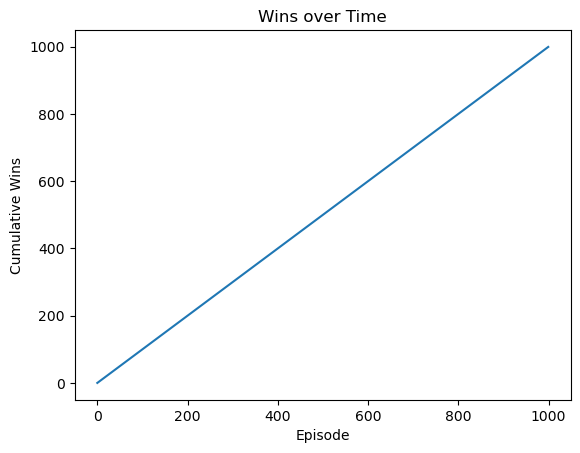

In [30]:
arr = [i for i in rewards_agent0 if i != 0]

plt.plot([sum(arr[:i]) for i in range(len(arr))])
plt.xlabel("Episode")
plt.ylabel("Cumulative Wins")
plt.title("Wins over Time")
plt.savefig("agent0_connect4_a2cvsDQN_cumuWins_CONT.png", bbox_inches='tight')